# Modelling Notebook

This notebook contains two modelling sections:
1. **Deep Learning (Neural Network)** — Predicts seasonally adjusted consumption tier (Low/Normal/High) per ACORN group
2. **LSTM** — Forecasts average household energy consumption using time series sequences

In [25]:
# Imports
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [26]:
# Data Paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))
DATA_DIR = os.path.join(PROJECT_ROOT, "build/datasets")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "build/results")

os.makedirs(RESULTS_DIR, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)

PROJECT_ROOT: /Users/max/Documents/Repos/TeamProjects/Team-Project-530
DATA_DIR: /Users/max/Documents/Repos/TeamProjects/Team-Project-530/build/datasets


In [27]:
# Load Raw Datasets
daily = pd.read_csv(os.path.join(DATA_DIR, "daily_dataset.csv"))
households = pd.read_csv(os.path.join(DATA_DIR, "informations_households.csv"))
weather_daily = pd.read_csv(os.path.join(DATA_DIR, "weather_daily_darksky.csv"))
holidays = pd.read_csv(os.path.join(DATA_DIR, "uk_bank_holidays.csv"))

print("Shapes:")
print("  daily:", daily.shape)
print("  households:", households.shape)
print("  weather_daily:", weather_daily.shape)
print("  holidays:", holidays.shape)

Shapes:
  daily: (3510433, 9)
  households: (5566, 5)
  weather_daily: (882, 32)
  holidays: (25, 2)


In [28]:
# Common Date Cleaning
daily["day"] = pd.to_datetime(daily["day"])

weather_daily["temperatureMaxTime"] = pd.to_datetime(weather_daily["temperatureMaxTime"])
weather_daily["temperatureMinTime"] = pd.to_datetime(weather_daily["temperatureMinTime"])
weather_daily["day"] = weather_daily["temperatureMaxTime"].dt.date

holidays = holidays.rename(columns={
    "Bank holidays": "day",
    "Type": "holiday_name"
})
holidays["day"] = pd.to_datetime(holidays["day"]).dt.date

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

print("Daily date range:", daily["day"].min().date(), "to", daily["day"].max().date())

Daily date range: 2011-11-23 to 2014-02-28


---
# Modelling: Deep Learning (Neural Network)

The Neural Network predicts a **seasonally adjusted consumption tier** (Low / Normal / High) for each ACORN socioeconomic group. The target is derived by ranking each group's daily consumption within its seasonal baseline and binning into terciles.

In [29]:
# NN-1: Preprocessing — ACORN-Segmented Aggregation

daily_nn = daily.copy()

# Merge with household info (Acorn_grouped only)
daily_ml = daily_nn.merge(
    households[["LCLid", "Acorn_grouped"]],
    on="LCLid",
    how="left"
)

# Filter to valid ACORN groups
valid_acorn_groups = ["Adversity", "Comfortable", "Affluent"]
daily_ml = daily_ml[daily_ml["Acorn_grouped"].isin(valid_acorn_groups)]

# Aggregate by day and Acorn_grouped
nn_dataset = (
    daily_ml
    .groupby(["day", "Acorn_grouped"])
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique")
    )
    .reset_index()
)

nn_dataset["avg_kwh_per_household_per_day"] = (
    nn_dataset["total_kwh_per_day"] / nn_dataset["num_active_households"]
)

nn_dataset["day"] = pd.to_datetime(nn_dataset["day"])

# Temporal features
nn_dataset["month"] = nn_dataset["day"].dt.month
nn_dataset["day_of_week"] = nn_dataset["day"].dt.dayofweek
nn_dataset["season"] = nn_dataset["month"].apply(get_season)

# Remove last row
nn_dataset = nn_dataset.iloc[:-1]

print("NN dataset after aggregation:", nn_dataset.shape)
display(nn_dataset.head())

NN dataset after aggregation: (2486, 8)


,day,Acorn_grouped,total_kwh_per_day,num_active_households,avg_kwh_per_household_per_day,month,day_of_week,season
0,2011-11-23,Adversity,11.4170,2,5.7085,11,2,Fall
1,2011-11-23,Affluent,46.2060,4,11.5515,11,2,Fall
2,2011-11-23,Comfortable,32.7620,7,4.6803,11,2,Fall
3,2011-11-24,Adversity,33.0030,4,8.2507,11,3,Fall
4,2011-11-24,Affluent,106.5490,10,10.6549,11,3,Fall


In [30]:
# NN-2: Merge Weather and Holidays

weather_nn = weather_daily[[
    "day", "temperatureHigh", "temperatureLow",
    "humidity", "windSpeed", "cloudCover", "pressure"
]].copy()
weather_nn["day"] = pd.to_datetime(weather_nn["day"])

nn_dataset = nn_dataset.merge(weather_nn, on="day", how="left")

# Merge holidays
holidays_dt = holidays.copy()
nn_dataset["day_only"] = nn_dataset["day"].dt.date

nn_dataset = nn_dataset.merge(
    pd.DataFrame({"day": holidays_dt["day"], "is_holiday": True}),
    left_on="day_only",
    right_on="day",
    how="left",
    suffixes=("", "_holiday")
)

nn_dataset["is_holiday"] = nn_dataset["is_holiday"].fillna(False)
nn_dataset = nn_dataset.drop(columns=["day_only", "day_holiday"], errors="ignore")

nn_dataset = nn_dataset.dropna()

print("NN dataset after merges:", nn_dataset.shape)
print("Missing values:", nn_dataset.isnull().sum().sum())

NN dataset after merges: (2483, 15)
Missing values: 0


In [31]:
# NN-3: Create Target Variable — Seasonally Adjusted Consumption Tier

# Percentile rank within each ACORN group x season
nn_dataset["seasonal_consumption_percentile"] = (
    nn_dataset
    .groupby(["Acorn_grouped", "season"])["avg_kwh_per_household_per_day"]
    .rank(pct=True)
)

# Bin into 3 consumption level classes: Low (0), Normal (1), High (2)
nn_dataset["consumption_level"] = pd.cut(
    nn_dataset["seasonal_consumption_percentile"],
    bins=[0, 1/3, 2/3, 1.0],
    labels=[0, 1, 2],
    include_lowest=True
).astype(int)

print("Target distribution:")
print(nn_dataset["consumption_level"].value_counts().sort_index())
print()
print("Class labels: 0=Low, 1=Normal, 2=High")

Target distribution:
consumption_level
0    824
1    825
2    834
Name: count, dtype: int64

Class labels: 0=Low, 1=Normal, 2=High


In [32]:
# NN-4: Prepare Features — Encode, Scale, Split

feature_cols = [
    "Acorn_grouped", "month", "day_of_week", "season",
    "is_holiday", "temperatureHigh", "temperatureLow",
    "humidity", "windSpeed", "cloudCover", "pressure",
    "num_active_households"
]
target_col = "consumption_level"
class_labels = ["Low", "Normal", "High"]

ml_model_data = nn_dataset[feature_cols + [target_col]].copy()

# Encode categoricals
le_acorn = LabelEncoder()
le_season = LabelEncoder()
ml_model_data["Acorn_grouped"] = le_acorn.fit_transform(ml_model_data["Acorn_grouped"])
ml_model_data["season"] = le_season.fit_transform(ml_model_data["season"])
ml_model_data["is_holiday"] = ml_model_data["is_holiday"].astype(int)

X_nn = ml_model_data[feature_cols].values
y_nn = ml_model_data[target_col].values

# Train/test split
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=42
)

# Scale features
scaler_nn = StandardScaler()
X_nn_train = scaler_nn.fit_transform(X_nn_train)
X_nn_test = scaler_nn.transform(X_nn_test)

print(f"Training samples: {X_nn_train.shape[0]}")
print(f"Test samples: {X_nn_test.shape[0]}")
print(f"Features: {len(feature_cols)}")

Training samples: 1986
Test samples: 497
Features: 12


In [33]:
# NN-5: Build Neural Network Classifier

np.random.seed(42)
tf.random.set_seed(42)

nn_model = models.Sequential([
    layers.InputLayer(input_shape=(len(feature_cols),)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_labels), activation='softmax')
])

nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

nn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# NN-6: Train Neural Network

nn_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-7
    )
]

print("Training Neural Network...")
nn_history = nn_model.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_test, y_nn_test),
    epochs=150,
    batch_size=64,
    callbacks=nn_callbacks,
    verbose=1
)

Training Neural Network...
Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4114 - loss: 1.0963 - val_accuracy: 0.4748 - val_loss: 1.0260 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4653 - loss: 1.0422 - val_accuracy: 0.5050 - val_loss: 0.9883 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4854 - loss: 1.0294 - val_accuracy: 0.5252 - val_loss: 0.9597 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5015 - loss: 0.9840 - val_accuracy: 0.5372 - val_loss: 0.9375 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5126 - loss: 0.9803 - val_accuracy: 0.5533 - val_loss: 0.9203 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5272 - loss: 0.9648 - val_accuracy: 0.5573 - val_loss: 0.9011 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.53

In [35]:
# NN-7: Evaluate Neural Network

y_nn_pred_probs = nn_model.predict(X_nn_test)
y_nn_pred = np.argmax(y_nn_pred_probs, axis=1)

nn_accuracy = accuracy_score(y_nn_test, y_nn_pred)

print(f"Accuracy: {nn_accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_nn_test, y_nn_pred, target_names=class_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.7002

Classification Report:
              precision    recall  f1-score   support

         Low       0.69      0.74      0.72       171
      Normal       0.57      0.58      0.58       154
        High       0.84      0.76      0.80       172

    accuracy                           0.70       497
   macro avg       0.70      0.70      0.70       497
weighted avg       0.71      0.70      0.70       497



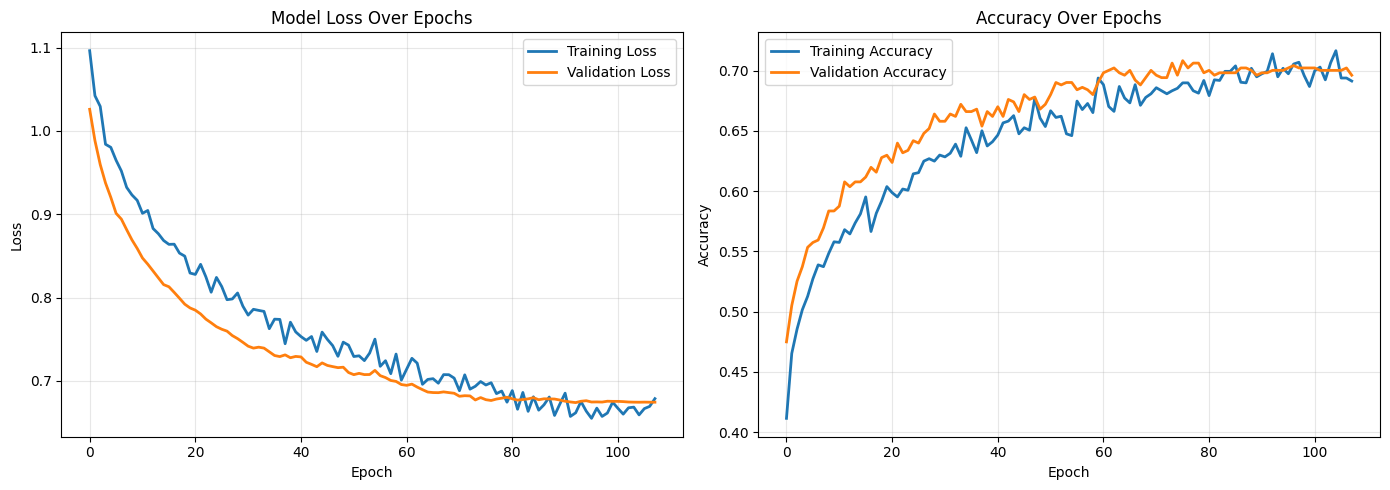

In [36]:
# NN-8: Training History

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(nn_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(nn_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(nn_history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(nn_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

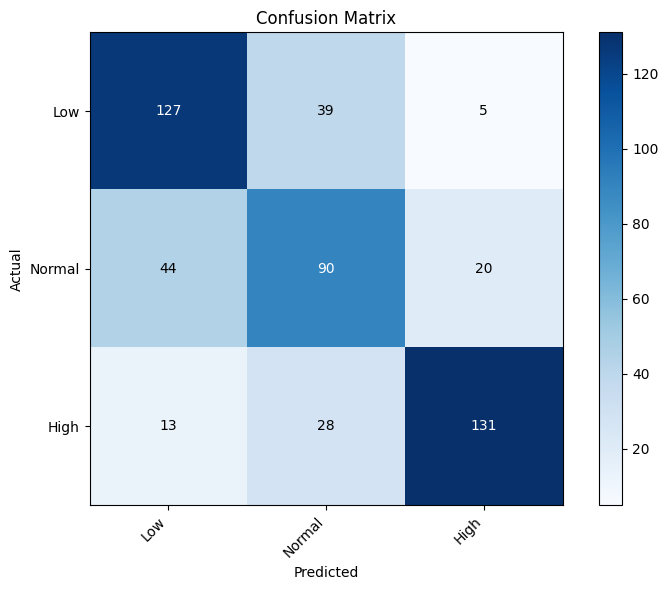

In [37]:
# NN-9: Confusion Matrix

cm = confusion_matrix(y_nn_test, y_nn_pred)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_labels,
       yticklabels=class_labels,
       xlabel='Predicted',
       ylabel='Actual',
       title='Confusion Matrix')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()

---
# Modelling: LSTM

The LSTM model forecasts `avg_kwh_per_household_per_day` using a univariate autoregressive approach — only past consumption values are used as input. The forecast horizon is configurable (default: 3 days ahead).

In [38]:
# LSTM-1: Preprocessing — Global Daily Aggregation

daily_lstm = daily.copy()
daily_lstm["day"] = pd.to_datetime(daily_lstm["day"])

# Temporal features
daily_lstm["month"] = daily_lstm["day"].dt.month
daily_lstm["day_of_week"] = daily_lstm["day"].dt.dayofweek
daily_lstm["season"] = daily_lstm["month"].apply(get_season)

# Aggregate across all households per day
lstm_dataset = (
    daily_lstm
    .groupby("day")
    .agg(
        total_kwh_per_day=("energy_sum", "sum"),
        num_active_households=("LCLid", "nunique"),
        month=("month", "first"),
        day_of_week=("day_of_week", "first"),
        season=("season", "first")
    )
    .reset_index()
)

lstm_dataset["avg_kwh_per_household_per_day"] = (
    lstm_dataset["total_kwh_per_day"] / lstm_dataset["num_active_households"]
)

# Sort by date
lstm_dataset = lstm_dataset.sort_values("day").reset_index(drop=True)

# Remove last row
lstm_dataset = lstm_dataset.iloc[:-1]

print("LSTM dataset shape:", lstm_dataset.shape)
print("Date range:", lstm_dataset["day"].min(), "to", lstm_dataset["day"].max())
display(lstm_dataset.head())

LSTM dataset shape: (828, 7)
Date range: 2011-11-23 00:00:00 to 2014-02-27 00:00:00


,day,total_kwh_per_day,num_active_households,month,day_of_week,season,avg_kwh_per_household_per_day
0,2011-11-23,90.3850,13,11,2,Fall,6.9527
1,2011-11-24,213.4120,25,11,3,Fall,8.5365
2,2011-11-25,303.9930,32,11,4,Fall,9.4998
3,2011-11-26,420.9760,41,11,5,Fall,10.2677
4,2011-11-27,444.8830,41,11,6,Fall,10.8508


In [39]:
# LSTM-2: Merge Weather and Holidays

weather_lstm = weather_daily[[
    "day", "temperatureHigh", "temperatureLow",
    "temperatureMax", "temperatureMin",
    "apparentTemperatureHigh", "apparentTemperatureLow",
    "humidity", "windSpeed", "cloudCover", "pressure", "visibility"
]].copy()

lstm_dataset["day_date"] = pd.to_datetime(lstm_dataset["day"]).dt.date
lstm_dataset = lstm_dataset.merge(
    weather_lstm, left_on="day_date", right_on="day",
    how="left", suffixes=("", "_weather")
)
lstm_dataset = lstm_dataset.drop(columns=["day_weather", "day_date"], errors="ignore")

# Merge holidays
lstm_dataset["day_date"] = pd.to_datetime(lstm_dataset["day"]).dt.date
lstm_dataset = lstm_dataset.merge(
    pd.DataFrame({"day": holidays["day"], "is_holiday": True}),
    left_on="day_date", right_on="day",
    how="left", suffixes=("", "_holiday")
)
lstm_dataset["is_holiday"] = lstm_dataset["is_holiday"].fillna(False).astype(int)
lstm_dataset = lstm_dataset.drop(columns=["day_date", "day_holiday"], errors="ignore")

print("LSTM dataset after merges:", lstm_dataset.shape)
print("Missing values per column:")
print(lstm_dataset.isnull().sum()[lstm_dataset.isnull().sum() > 0])

LSTM dataset after merges: (839, 19)
Missing values per column:
temperatureHigh            11
temperatureLow             11
temperatureMax             11
temperatureMin             11
apparentTemperatureHigh    11
apparentTemperatureLow     11
humidity                   11
windSpeed                  11
cloudCover                 12
pressure                   11
visibility                 11
dtype: int64


In [40]:
# LSTM-3: Configure Model and Prepare Sequences

# Hyperparameters
SEQUENCE_LENGTH = 48
FORECAST_HORIZON = 3
LSTM_UNITS = 75
NUM_LAYERS = 3
DROPOUT_RATE = 0.2
TRAIN_SPLIT = 0.7

# Univariate: use only past consumption values
target_col_lstm = "avg_kwh_per_household_per_day"

# Extract target and dates
lstm_target = lstm_dataset[target_col_lstm].values.reshape(-1, 1)
lstm_dates = lstm_dataset["day"].values

# Scale
scaler_lstm = MinMaxScaler()
lstm_target_scaled = scaler_lstm.fit_transform(lstm_target)

# Create sequences with forecast horizon offset
def create_sequences(data, target, sequence_length, forecast_horizon):
    X, y = [], []
    offset = forecast_horizon - 1
    for i in range(len(data) - sequence_length - offset):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length + offset])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(
    lstm_target_scaled, lstm_target_scaled, SEQUENCE_LENGTH, FORECAST_HORIZON
)

print(f"Mode: Univariate (autoregressive)")
print(f"Forecast horizon: {FORECAST_HORIZON} days ahead")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"X shape: {X_lstm.shape}")
print(f"y shape: {y_lstm.shape}")

Mode: Univariate (autoregressive)
Forecast horizon: 3 days ahead
Sequence length: 48
X shape: (789, 48, 1)
y shape: (789, 1)


In [41]:
# LSTM-4: Time-Based Train/Test Split

split_idx = int(len(X_lstm) * TRAIN_SPLIT)

X_lstm_train = X_lstm[:split_idx]
X_lstm_test = X_lstm[split_idx:]
y_lstm_train = y_lstm[:split_idx]
y_lstm_test = y_lstm[split_idx:]

print(f"Training sequences: {X_lstm_train.shape}")
print(f"Test sequences: {X_lstm_test.shape}")

Training sequences: (552, 48, 1)
Test sequences: (237, 48, 1)


In [42]:
# LSTM-5: Build LSTM Model

tf.random.set_seed(42)
np.random.seed(42)

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

lstm_model = Sequential()

for i in range(NUM_LAYERS):
    if i == 0:
        lstm_model.add(LSTM(
            units=LSTM_UNITS,
            input_shape=(SEQUENCE_LENGTH, X_lstm_train.shape[2]),
            return_sequences=(i < NUM_LAYERS - 1)
        ))
    else:
        lstm_model.add(LSTM(
            units=LSTM_UNITS,
            return_sequences=(i < NUM_LAYERS - 1)
        ))
    lstm_model.add(Dropout(DROPOUT_RATE))

lstm_model.add(Dense(1, activation='linear'))

lstm_model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae']
)

lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 48, 75)         │        23,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 48, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 48, 75)         │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 48, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 75)             │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,776 (444.44 KB)

 Trainable params: 113,776 (444.44 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# LSTM-6: Train LSTM Model

lstm_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_lstm_train, y_lstm_train,
    validation_data=(X_lstm_test, y_lstm_test),
    epochs=50,
    batch_size=32,
    callbacks=lstm_callbacks,
    verbose=1
)

Training LSTM model...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0307 - mae: 0.1284 - val_loss: 0.0046 - val_mae: 0.0559
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0134 - mae: 0.0886 - val_loss: 0.0106 - val_mae: 0.0811
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0123 - mae: 0.0823 - val_loss: 0.0047 - val_mae: 0.0524
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0109 - mae: 0.0790 - val_loss: 0.0049 - val_mae: 0.0529
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0115 - mae: 0.0788 - val_loss: 0.0036 - val_mae: 0.0457
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0098 - mae: 0.0753 - val_loss: 0.0052 - val_mae: 0.0545
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0095 - mae: 0.0729 - val_loss: 0.0037 - val_mae: 0.0450
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0094 - mae: 0.0723 - val_loss: 0.0031 - val_mae: 0.0422
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [44]:
# LSTM-7: Evaluate LSTM Model

# Predictions
y_lstm_pred_train = lstm_model.predict(X_lstm_train)
y_lstm_pred_test = lstm_model.predict(X_lstm_test)

# Inverse transform
y_lstm_train_actual = scaler_lstm.inverse_transform(y_lstm_train.reshape(-1, 1))
y_lstm_pred_train_actual = scaler_lstm.inverse_transform(y_lstm_pred_train)
y_lstm_test_actual = scaler_lstm.inverse_transform(y_lstm_test.reshape(-1, 1))
y_lstm_pred_test_actual = scaler_lstm.inverse_transform(y_lstm_pred_test)

# Metrics
lstm_test_rmse = np.sqrt(mean_squared_error(y_lstm_test_actual, y_lstm_pred_test_actual))
lstm_test_mae = mean_absolute_error(y_lstm_test_actual, y_lstm_pred_test_actual)
lstm_test_r2 = r2_score(y_lstm_test_actual, y_lstm_pred_test_actual)

print("=" * 60)
print("LSTM MODEL PERFORMANCE")
print("=" * 60)
print(f"  RMSE: {lstm_test_rmse:.4f}")
print(f"  MAE:  {lstm_test_mae:.4f}")
print(f"  R\u00b2:   {lstm_test_r2:.4f}")
print("=" * 60)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM MODEL PERFORMANCE
  RMSE: 0.4490
  MAE:  0.3383
  R²:   0.9170


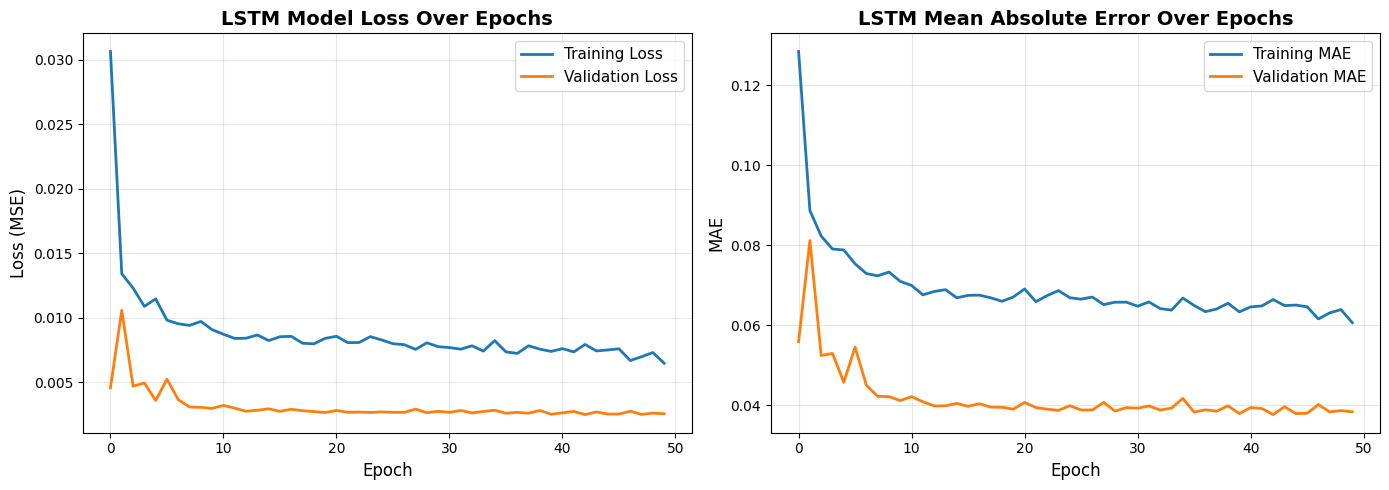

In [45]:
# LSTM-8: Training History

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('LSTM Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(lstm_history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(lstm_history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('LSTM Mean Absolute Error Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

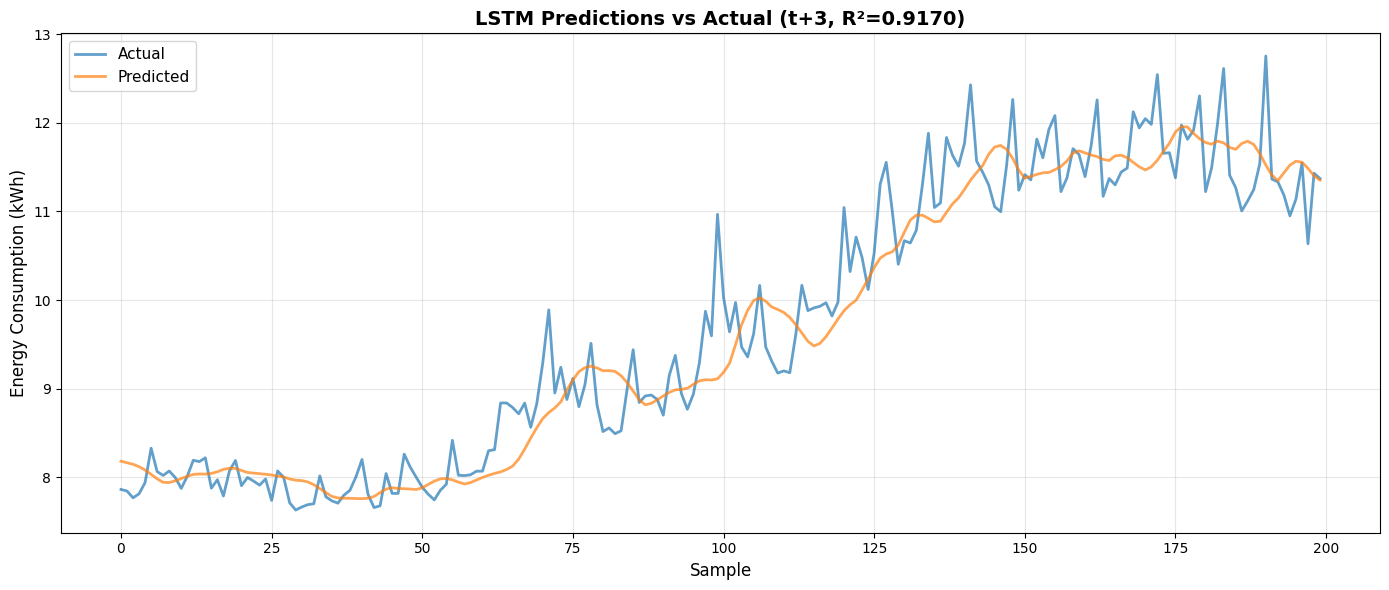

In [46]:
# LSTM-9: Predictions vs Actual

plot_samples = min(200, len(y_lstm_test_actual))

plt.figure(figsize=(14, 6))
plt.plot(y_lstm_test_actual[:plot_samples], label='Actual', alpha=0.7, linewidth=2)
plt.plot(y_lstm_pred_test_actual[:plot_samples], label='Predicted', alpha=0.7, linewidth=2)
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.title(f'LSTM Predictions vs Actual (t+{FORECAST_HORIZON}, R\u00b2={lstm_test_r2:.4f})',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

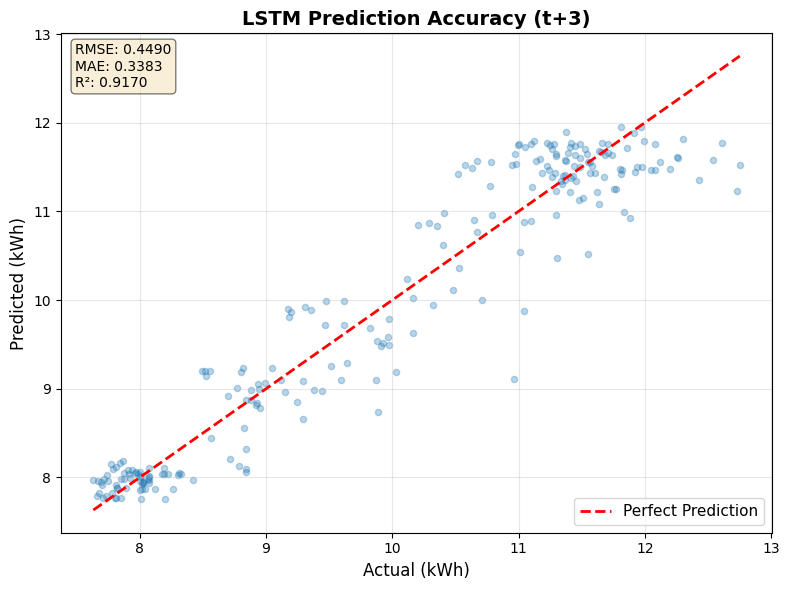

In [47]:
# LSTM-10: Scatter Plot — Predictions vs Actual

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(y_lstm_test_actual, y_lstm_pred_test_actual, alpha=0.3, s=20)

min_val = min(y_lstm_test_actual.min(), y_lstm_pred_test_actual.min())
max_val = max(y_lstm_test_actual.max(), y_lstm_pred_test_actual.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

metrics_text = f'RMSE: {lstm_test_rmse:.4f}\nMAE: {lstm_test_mae:.4f}\nR\u00b2: {lstm_test_r2:.4f}'
ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=10)

ax.set_xlabel('Actual (kWh)', fontsize=12)
ax.set_ylabel('Predicted (kWh)', fontsize=12)
ax.set_title(f'LSTM Prediction Accuracy (t+{FORECAST_HORIZON})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [48]:
# LSTM-11: Export Predictions for Tableau

# Align predictions to the dates they target
target_offset = SEQUENCE_LENGTH + FORECAST_HORIZON - 1
n_train = len(y_lstm_pred_train_actual)
n_test = len(y_lstm_pred_test_actual)
aligned_dates = lstm_dates[target_offset : target_offset + n_train + n_test]

export_df = pd.DataFrame({
    'day': aligned_dates,
    'avg_kwh_per_household_per_day': np.concatenate([
        y_lstm_train_actual.flatten(), y_lstm_test_actual.flatten()
    ]),
    'predicted_avg_kwh': np.concatenate([
        y_lstm_pred_train_actual.flatten(), y_lstm_pred_test_actual.flatten()
    ]),
    'split': ['train'] * n_train + ['test'] * n_test
})

export_path = os.path.join(RESULTS_DIR, 'lstm_tableau_export.csv')
export_df.to_csv(export_path, index=False)

print(f"Exported {len(export_df)} predictions to {export_path}")
print(f"  Train rows: {n_train}")
print(f"  Test rows: {n_test}")
print(f"\nPreview:")
display(export_df.head(10))
print("...")
display(export_df.tail(10))

Exported 789 predictions to /Users/max/Documents/Repos/TeamProjects/Team-Project-530/build/results/lstm_tableau_export.csv
  Train rows: 552
  Test rows: 237

Preview:


,day,avg_kwh_per_household_per_day,predicted_avg_kwh,split
0,2012-01-12,12.0568,12.7005,train
1,2012-01-13,12.5228,12.6014,train
2,2012-01-14,13.4963,12.4437,train
3,2012-01-15,14.0372,12.2784,train
4,2012-01-16,13.0478,12.1753,train
5,2012-01-17,13.2671,12.2235,train
6,2012-01-18,12.7892,12.4371,train
7,2012-01-19,12.2748,12.6454,train
8,2012-01-20,12.7830,12.8156,train
9,2012-01-21,12.7356,12.8863,train


...


,day,avg_kwh_per_household_per_day,predicted_avg_kwh,split
779,2014-02-18,10.7819,11.5527,test
780,2014-02-19,10.6746,11.5642,test
781,2014-02-20,10.5738,11.5218,test
782,2014-02-21,10.5181,11.4225,test
783,2014-02-22,10.7762,11.2850,test
784,2014-02-23,11.4804,11.1304,test
785,2014-02-24,10.4114,10.9779,test
786,2014-02-25,10.2950,10.8640,test
787,2014-02-26,10.2029,10.8486,test
788,2014-02-27,10.3563,10.8331,test
